# Stock trend prediction with Machine Learning (random forests)
takes pretrained Random forest model and runs predictions on unseen data.

In [ ]:
!pip install talib-binary
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import talib as ta
import yfinance as yf
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

# ML related imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
# --- additional setup ---
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#suppress 'SettingWithCopy' warning
pd.set_option('mode.chained_assignment', None)

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

# colab/jupyter setup
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [ ]:

start_time = datetime.datetime(2021, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

## Function definitions

In [ ]:
def get_data(ticker):
    # yahoo API
    connected = False
    while not connected:
        try:
            df = yf.download(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    df = df.reset_index()
    #print(df.head(5))
    return df

In [ ]:
def compute_technical_indicators(df):
    df['EMA5'] = ta.EMA(df['Adj Close'].values, timeperiod=5)
    df['EMA10'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA15'] = ta.EMA(df['Adj Close'].values, timeperiod=15)
    df['EMA20'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA30'] = ta.EMA(df['Adj Close'].values, timeperiod=30)
    df['EMA40'] = ta.EMA(df['Adj Close'].values, timeperiod=40)
    df['EMA50'] = ta.EMA(df['Adj Close'].values, timeperiod=50)

    df['EMA60'] = ta.EMA(df['Adj Close'].values, timeperiod=60)
    df['EMA70'] = ta.EMA(df['Adj Close'].values, timeperiod=70)
    df['EMA80'] = ta.EMA(df['Adj Close'].values, timeperiod=80)
    df['EMA90'] = ta.EMA(df['Adj Close'].values, timeperiod=90)
    
    df['EMA100'] = ta.EMA(df['Adj Close'].values, timeperiod=100)
    df['EMA150'] = ta.EMA(df['Adj Close'].values, timeperiod=150)
    df['EMA200'] = ta.EMA(df['Adj Close'].values, timeperiod=200)

    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Adj Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    df['SAR'] = ta.SAR(df['High'].values, df['Low'].values, acceleration=0.02, maximum=0.2)

    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14)

    df.tail()

    return df

In [ ]:
def compute_features(df):
    # computes features for forest decisions
    df['aboveEMA5'] = np.where(df['Adj Close'] > df['EMA5'], 1, -1)
    df['aboveEMA10'] = np.where(df['Adj Close'] > df['EMA10'], 1, -1)
    df['aboveEMA15'] = np.where(df['Adj Close'] > df['EMA15'], 1, -1)
    df['aboveEMA20'] = np.where(df['Adj Close'] > df['EMA20'], 1, -1)
    df['aboveEMA30'] = np.where(df['Adj Close'] > df['EMA30'], 1, -1)
    df['aboveEMA40'] = np.where(df['Adj Close'] > df['EMA40'], 1, -1)
    
    df['aboveEMA50'] = np.where(df['Adj Close'] > df['EMA50'], 1, -1)
    df['aboveEMA60'] = np.where(df['Adj Close'] > df['EMA60'], 1, -1)
    df['aboveEMA70'] = np.where(df['Adj Close'] > df['EMA70'], 1, -1)
    df['aboveEMA80'] = np.where(df['Adj Close'] > df['EMA80'], 1, -1)
    df['aboveEMA90'] = np.where(df['Adj Close'] > df['EMA90'], 1, -1)
    
    df['aboveEMA100'] = np.where(df['Adj Close'] > df['EMA100'], 1, -1)
    df['aboveEMA150'] = np.where(df['Adj Close'] > df['EMA150'], 1, -1)
    df['aboveEMA200'] = np.where(df['Adj Close'] > df['EMA200'], 1, -1)

    df['aboveUpperBB'] = np.where(df['Adj Close'] > df['upperBB'], 1, -1)
    df['belowLowerBB'] = np.where(df['Adj Close'] < df['lowerBB'], 1, -1)
    
    df['aboveSAR'] = np.where(df['Adj Close'] > df['SAR'], 1, -1)
   
    df['oversoldRSI'] = np.where(df['RSI'] < 30, 1, -1)
    df['overboughtRSI'] = np.where(df['RSI'] > 70, 1, -1)


    # very important - cleanup NaN values, otherwise prediction does not work
    df=df.fillna(0).copy()
    
    #df.tail()

    return df

In [ ]:
def plot_train_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title('Stock data ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

In [ ]:
def define_target_condition(df):
 
    # price higher later - bad predictive results
    #df['target_cls'] = np.where(df['Adj Close'].shift(-34) > df['Adj Close'], 1, 0)    
    
    # price above trend multiple days later
    df['target_cls'] = np.where(df['Adj Close'].shift(-55) > df.EMA150.shift(-55), 1, 0)

    # important, remove NaN values
    df=df.fillna(0).copy()
    
    df.tail()
    
    return df

In [ ]:
def predict_timeseries(df, clf):
    
    df['Buy'] = np.nan
    
    for i in range(len(df)):
        X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                        df['RSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                        df['aboveEMA5'][i],df['aboveEMA10'][i],df['aboveEMA15'][i],df['aboveEMA20'][i],
                        df['aboveEMA30'][i],df['aboveEMA40'][i],df['aboveEMA50'][i],
                        df['aboveEMA60'][i],df['aboveEMA70'][i],df['aboveEMA80'][i],df['aboveEMA90'][i],
                        df['aboveEMA100'][i]]]    

        y_cls_pred_valid = clf.predict(X_cls_valid)
        df['Buy'][i] = y_cls_pred_valid[0].copy()
        print('df[Buy][i]',i , df['Buy'][i])

    #print(df.head())    
        
    return df

In [ ]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(20,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='High', alpha=0.2)

    plt.plot(df['Date'], df['EMA10'], label='EMA10', alpha=0.2)
    plt.plot(df['Date'], df['EMA20'], label='EMA20', alpha=0.2)
    plt.plot(df['Date'], df['EMA30'], label='EMA30', alpha=0.2)
    plt.plot(df['Date'], df['EMA40'], label='EMA40', alpha=0.2)
    plt.plot(df['Date'], df['EMA50'], label='EMA50', alpha=0.2)
    plt.plot(df['Date'], df['EMA100'], label='EMA100', alpha=0.2)
    plt.plot(df['Date'], df['EMA150'], label='EMA150', alpha=0.99)
    plt.plot(df['Date'], df['EMA200'], label='EMA200', alpha=0.2)


    plt.scatter(df['Date'], df['Buy']*df['Adj Close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()

    return None   

# Prediction
Here the model will perform trend predictions on an unknown dataset (has not seen it during training or testing).

In [ ]:
#ticker='BP'
#ticker='ABBV'
ticker='GILD'
#ticker='NGG'


In [ ]:
# load classifier, no need to initialize the loaded_rf
loaded_clf = joblib.load("./random_forest.joblib")
clf = loaded_clf

In [ ]:
new_df = get_data(ticker)

[*********************100%***********************]  1 of 1 completed
connected to yahoo


In [ ]:
new_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,58.669998,60.160000,57.930000,60.110001,56.219360,15520000
1,2021-01-05,60.230000,60.450001,59.619999,60.000000,56.116482,13251100
2,2021-01-06,59.700001,62.080002,59.700001,61.950001,57.940266,12222500
3,2021-01-07,61.900002,63.240002,61.520000,62.520000,58.473370,10614700
4,2021-01-08,62.610001,63.410000,62.509998,63.040001,58.959713,8389800


In [ ]:
#new_df.to_numpy()

In [ ]:
new_df = compute_technical_indicators(new_df)

In [ ]:
new_df = compute_features(new_df)

In [ ]:
new_df=define_target_condition(new_df)

In [ ]:
new_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,EMA5,EMA10,EMA15,...,aboveEMA90,aboveEMA100,aboveEMA150,aboveEMA200,aboveUpperBB,belowLowerBB,aboveSAR,oversoldRSI,overboughtRSI,target_cls
396,2022-08-01,59.770000,60.180000,59.270000,59.599998,59.599998,6742400,60.147425,60.615932,60.905779,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
397,2022-08-02,59.740002,60.320000,59.290001,59.540001,59.540001,5981600,59.944950,60.420308,60.735057,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
398,2022-08-03,60.869999,63.650002,60.639999,62.270000,62.270000,10066700,60.719967,60.756616,60.926925,...,1,1,1,-1,-1,-1,1,-1,-1,0
399,2022-08-04,62.139999,62.990002,61.830002,61.910000,61.910000,5520500,61.116645,60.966322,61.049809,...,1,1,-1,-1,-1,-1,1,-1,-1,0
400,2022-08-05,61.790001,61.840000,60.619999,61.090000,61.090000,6039600,61.107763,60.988809,61.054833,...,-1,-1,-1,-1,-1,-1,1,-1,-1,0


In [ ]:
# https://stackoverflow.com/questions/69326639/sklearn-warning-valid-feature-names-in-version-1-0

In [ ]:
import time

In [ ]:
df = new_df.copy()

i = 1
X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                df['RSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                df['aboveEMA5'][i],df['aboveEMA10'][i],df['aboveEMA15'][i],df['aboveEMA20'][i],
                df['aboveEMA30'][i],df['aboveEMA40'][i],df['aboveEMA50'][i],
                df['aboveEMA60'][i],df['aboveEMA70'][i],df['aboveEMA80'][i],df['aboveEMA90'][i],
                df['aboveEMA100'][i]]]    



print('X_cls_valid: ', X_cls_valid)


s_time = time.time()
y_cls_pred_valid = clf.predict(X_cls_valid)
e_time=time.time()
  

X_cls_valid:  [[-1, -1, -1, 0.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]


In [ ]:
y_cls_pred_valid

array([1])

In [ ]:
e_time - s_time # single prediction duration should be about 0.2 seconds

0.2112579345703125

In [ ]:
#new_df = predict_timeseries(new_df, clf)
predict_timeseries(new_df, clf)

df[Buy][i] 0 1.0
df[Buy][i] 1 1.0
df[Buy][i] 2 1.0
df[Buy][i] 3 1.0
df[Buy][i] 4 1.0
df[Buy][i] 5 0.0
df[Buy][i] 6 0.0
df[Buy][i] 7 1.0
df[Buy][i] 8 0.0
df[Buy][i] 9 0.0
df[Buy][i] 10 1.0
df[Buy][i] 11 1.0
df[Buy][i] 12 1.0
df[Buy][i] 13 0.0
df[Buy][i] 14 1.0
df[Buy][i] 15 1.0
df[Buy][i] 16 1.0
df[Buy][i] 17 1.0
df[Buy][i] 18 1.0
df[Buy][i] 19 1.0
df[Buy][i] 20 1.0
df[Buy][i] 21 1.0
df[Buy][i] 22 1.0
df[Buy][i] 23 1.0
df[Buy][i] 24 1.0
df[Buy][i] 25 1.0
df[Buy][i] 26 1.0
df[Buy][i] 27 1.0
df[Buy][i] 28 1.0
df[Buy][i] 29 1.0
df[Buy][i] 30 1.0
df[Buy][i] 31 1.0
df[Buy][i] 32 1.0
df[Buy][i] 33 0.0
df[Buy][i] 34 0.0
df[Buy][i] 35 0.0
df[Buy][i] 36 0.0
df[Buy][i] 37 0.0
df[Buy][i] 38 0.0
df[Buy][i] 39 0.0
df[Buy][i] 40 0.0
df[Buy][i] 41 0.0
df[Buy][i] 42 1.0
df[Buy][i] 43 1.0
df[Buy][i] 44 1.0
df[Buy][i] 45 0.0
df[Buy][i] 46 0.0
df[Buy][i] 47 0.0
df[Buy][i] 48 1.0
df[Buy][i] 49 1.0
df[Buy][i] 50 1.0
df[Buy][i] 51 1.0
df[Buy][i] 52 1.0
df[Buy][i] 53 1.0
df[Buy][i] 54 1.0
df[Buy][i] 55 1.0
df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA5,EMA10,EMA15,...,aboveEMA100,aboveEMA150,aboveEMA200,aboveUpperBB,belowLowerBB,aboveSAR,oversoldRSI,overboughtRSI,target_cls,Buy
0,2021-01-04,58.669998,60.160000,57.930000,60.110001,56.219360,15520000,0.000000,0.000000,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,1,1.0
1,2021-01-05,60.230000,60.450001,59.619999,60.000000,56.116482,13251100,0.000000,0.000000,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,1,1.0
2,2021-01-06,59.700001,62.080002,59.700001,61.950001,57.940266,12222500,0.000000,0.000000,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,1,1.0
3,2021-01-07,61.900002,63.240002,61.520000,62.520000,58.473370,10614700,0.000000,0.000000,0.000000,...,-1,-1,-1,-1,-1,1,-1,-1,1,1.0
4,2021-01-08,62.610001,63.410000,62.509998,63.040001,58.959713,8389800,57.541838,0.000000,0.000000,...,-1,-1,-1,-1,-1,1,-1,-1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2022-08-01,59.770000,60.180000,59.270000,59.599998,59.599998,6742400,60.147425,60.615932,60.905779,...,-1,-1,-1,-1,-1,-1,-1,-1,0,0.0
397,2022-08-02,59.740002,60.320000,59.290001,59.540001,59.540001,5981600,59.944950,60.420308,60.735057,...,-1,-1,-1,-1,-1,-1,-1,-1,0,0.0
398,2022-08-03,60.869999,63.650002,60.639999,62.270000,62.270000,10066700,60.719967,60.756616,60.926925,...,1,1,-1,-1,-1,1,-1,-1,0,1.0
399,2022-08-04,62.139999,62.990002,61.830002,61.910000,61.910000,5520500,61.116645,60.966322,61.049809,...,1,-1,-1,-1,-1,1,-1,-1,0,1.0


Below plot is showing predictions on unseen dataset. When the triangle overlay is on the price data, it means buy. When the triangle is on the zero level, it means, don't buy. This model is pretty much giving only long signals, but can be extrapolated to sell signals as well.

So the Buy signal means, that the model thinks that in n days (here 55 days) the price will be above specific Exponencial Moving Average (here was trained to be above 150 EMA in 55 days).

We see that the model is giving some false positive signals (of course it is), but not that many actually. It just sometimes expects trend reversal too early, but if we are using this as an investing advisor for long term hold or long term swing trades, the signals provided by the model are very nice.

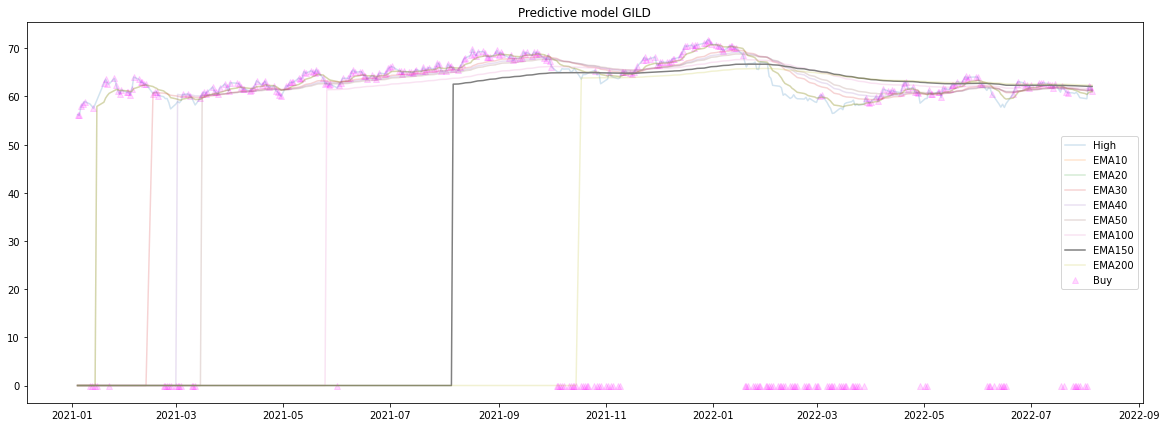

In [ ]:
plot_stock_prediction(new_df, ticker)

### Summary:
Wisdom of the trees (and forests):
Trend is your friend until the end.

### Sources:
https://blog.quantinsti.com/decision-tree/
https://blog.quantinsti.com/parabolic-sar/
https://mljar.com/blog/save-load-random-forest/